# Parameter Estimation for PEtab problems in Julia

When modeling biological systems such as insulin signaling, a subset of model kinetic parameters are unknown. For instance, in the setting of insulin signaling the rate of glucose uptake might be unknown. With quantitative time-lapse data these unknown parameters can be estimated by running parameter estimation. This process involves solving numerical optimization to find parameter values that minimize the discrepancy between the model's predictions and the observed experimental data.

PEtab.jl allows parameter estimation problems to be specified directly in Julia (see ADD), or it can import problems in the PEtab standard format. Once it has parsed a problem, PEtab.jl generates a negative likelihood function that quantifies the deviation between model outputs and experimental observations. Additionally, it generates functions for computing the likelihood's gradient. This notebook will showcase how to perform parameter estimation for a PEtab.jl parsed parameter estimation problem.

During parameter estimation the model gradient is computed many times. Therefore, we recomend to first explore the notebook showcasing various gradient computation methods.

## Setup

The packages needed are:

- **PEtab.jl**: For importing PEtab problems.
- **OrdinaryDiffEq.jl**: For simulating ODE models.
- **Plots.jl** and **StatsPlots.jl**: For visualizing simulation results.
- **Optim.jl** and **PyCall.jl**: For parameter estimation.

In [1]:
using PEtab, OrdinaryDiffEq, Plots, StatsPlots, Optim

We use PyCall to access the [Fides](https://github.com/fides-dev/fides) optimizer. To properly install Fides with PyCall do:

In [2]:
using PyCall
# Set the path to your Python executable in environment with Fides installed
# Note - path is specific to your system!
path_python_exe = "/home/sebpe/anaconda3/envs/PeTab/bin/python"
# Set the PYTHON environment variable to the path of your Python executable
ENV["PYTHON"] = path_python_exe
# Build PyCall with the specified Python environment
import Pkg
Pkg.build("PyCall")

    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/51cab8e982c5b598eea9c8ceaced4b58d9dd37c9/build.log`


    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/9816a3826b0ebf49ab4926e2b18842ad8b5c8f04/build.log`


After building PyCall you might have to restart Julia.

## Parameter Estimation Using Exact Hessian

Here using a Jak-Stat signaling model as case-study, with its PEtab problem files found in the *Assets/Boehm_JProteomeRes2014/* directory, we showcase how to perform parameter estimation with the help of the Hessian. To begin, we import the PEtab problem into Julia, with detailed instructions available in a [separate notebook](https://github.com/sebapersson/SysBioNotebooks/blob/main/Simulate_model/PEtab_ODE.ipynb).

In [3]:
path_petab_problem = joinpath(@__DIR__, "Assets", "Boehm_JProteomeRes2014", "Boehm_JProteomeRes2014.yaml")
petab_model = PEtabModel(path_petab_problem; verbose=false)
petab_problem = PEtabODEProblem(petab_model; verbose=false)
xpetab = petab_problem.θ_nominalT
xpetab_names = petab_problem.θ_names
# Print parameters
[(xpetab_names[i] => xpetab[i]) for i in eachindex(xpetab)]

9-element Vector{Pair{Symbol, Float64}}:
 :Epo_degradation_BaF3 => -1.5689175883999988
         :k_exp_hetero => -4.999704893599998
           :k_exp_homo => -2.2096987817000167
         :k_imp_hetero => -1.78600654750001
           :k_imp_homo => 4.9901140088
               :k_phos => 4.1977354885
       :sd_pSTAT5A_rel => 0.5857552705999998
       :sd_pSTAT5B_rel => 0.8189828191999999
       :sd_rSTAT5A_rel => 0.49868440400000047

Here `xpetab_names` is the name of the parameters to estimate (specified in the PEtab problem files). When doing parameter estimation there are two important considerations: the choice of methods for computing model derivatives, and the choice of parameter estimation algorithm.

For gradient computation PEtab.jl's defaults setting are often suitable, but general notes on choosing gradient methods can be found in this [notebook](https://github.com/sebapersson/SysBioNotebooks/blob/main/Simulate_model/PEtab_gradients.ipynb). In addition, PEtab.jl can also compute the Hessian matrix (second order derivatives), and for smaller models it is typically computationally feasible to compute the Hessian, but for larger models, the Hessian most typically be approximated.

The likelihood function which describes the discrepancy between model predictions and observed data, often has multiple local minima. A good way to find the global minimum, is to perform multi-start parameter estimation where several optimization runs are performed from random starting points. Then, for each optimization run a local parameter estimation algorithm is used. When feasible to compute the Hessian, [Optims's](https://github.com/JuliaNLSolvers/Optim.jl) Interior-Point Newton method (`IPNewton()`) often perform well. Another good option is the Newton-Trust region method `Fides`, where the user can choose to use a Hessian approximation or the exact Hessian.

To showcase all this, as a case-study let us conduct a multi-start parameter estimation using both `IPNewton()` and `Fides`, where for `Fides` we test using the full Hessian and the BFGS Hessian approximation. First focusing on `IPNewton()`, we consider 50 multi-starts (in real life using at least 100 multi-starts is recommended).

In [10]:
import Random
# For reproducibillity
Random.seed!(123)
res_optim = calibrate_model_multistart(petab_problem, IPNewton(), 50, nothing)

PEtabMultistartOptimisationResult
--------- Summary ---------
min(f)                = 1.38e+02
Parameters esimtated  = 9
Number of multistarts = 50
Optimiser algorithm   = Optim_IPNewton


The result object `res_optim` from the parameter estimation contains information such as the minimized parameter values (`res_optim.xmin`), the minimum likelihood value achieved (`res_optim.fmin`), and parameter estimation results from each run (`res_optim.runs`). For this case, we can see that the minimum likelihood value obtained (`res_optim.fmin`) is 138, which for this model is the global minimum. To further analyze the outcomes of the parameter estimation run, a waterfall plot is useful:

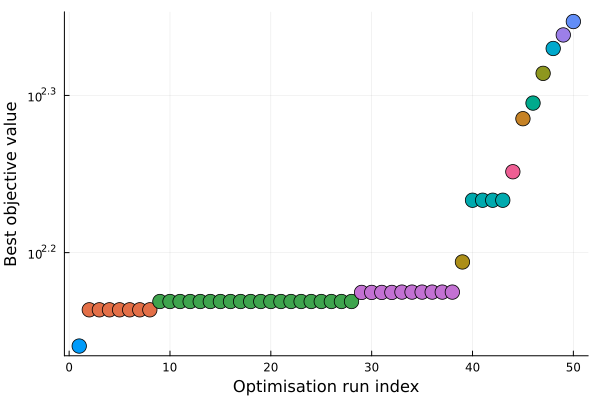

In [11]:
plot(res_optim, plot_type=:waterfall)

The waterfall plot is a standard tool for diagnosing parameter estimation runs, and it shows the final likelihood values from each run, organized in ascending order. Ideally multiple runs to converge to the lowest point, in order to be sure that the global minimum has been found. For more possible plots, see [here](https://sebapersson.github.io/PEtab.jl/stable/optimisation_output_plotting/#Waterfall-plots). 

Next, let us examine the parameter estimation results using `Fides`, where the full Hessian is computed.

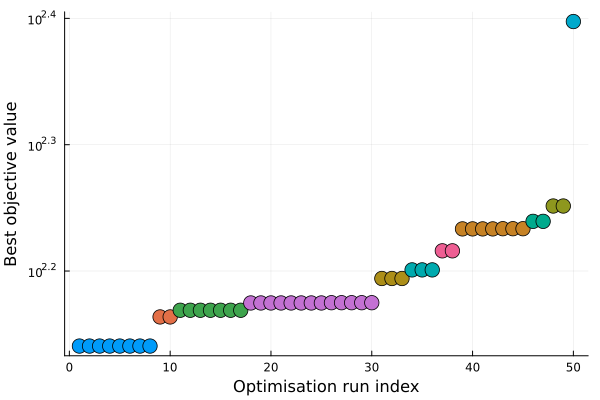

In [13]:
using Suppressor
Random.seed!(123)
alg = Fides(nothing; verbose=false)
# To avoid Fides printing progress
res_fides = nothing
@suppress begin
    res_fides = calibrate_model_multistart(petab_problem, alg, 50, nothing)
end
plot(res_fides, plot_type=:waterfall)

Lastly we can try `Fides` when the Hessian is approximated with the BFGS method (for full list of Hessian approximations for `Fides` see [here](https://sebapersson.github.io/PEtab.jl/stable/Avaible_optimisers/#Fides))

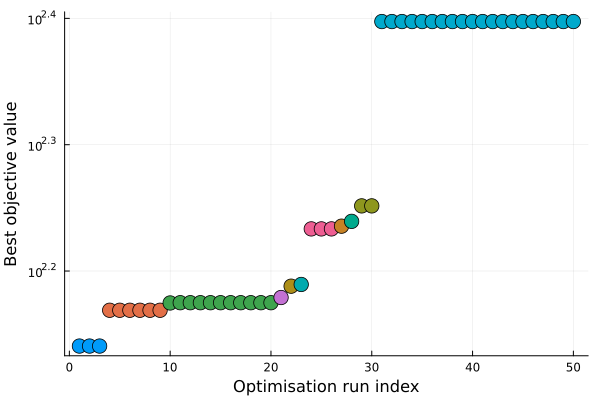

In [6]:
Random.seed!(123)
alg = Fides(:BFGS; verbose=false)
# To avoid Fides printing progress
res_bfgs = nothing
@suppress begin
    res_bfgs = calibrate_model_multistart(petab_problem, alg, 50, nothing)
end
plot(res_bfgs, plot_type=:waterfall)

Since we do not compute the full Hessian with `Fides(:BFGS)`, it is the fastest method as seen from the total runtime

In [15]:
using Printf
runtime_bfgs = sum([res_bfgs.runs[i].runtime for i in eachindex(res_bfgs.runs)])
runtime_fides = sum([res_fides.runs[i].runtime for i in eachindex(res_fides.runs)])
runtime_optim = sum([res_optim.runs[i].runtime for i in eachindex(res_optim.runs)])
@printf("Runtime Optim IPNewton : %.1f seconds\n", runtime_optim)
@printf("Runtime Fides Hessian  : %.1f seconds\n", runtime_fides)
@printf("Runtime Fides BFGS     : %.1f  seconds\n", runtime_bfgs)

Runtime Optim IPNewton : 145.9 seconds
Runtime Fides Hessian  : 275.0 seconds
Runtime Fides BFGS     : 22.3  seconds


If we consider the number of multi-starts that converged to the global optima though, `Fides` with full Hessian perform best.

In [16]:
best_f = res_fides.fmin
nfides = sum([res_fides.runs[i].fmin < best_f+0.1 for i in eachindex(res_fides.runs)])
nbfgs = sum([res_bfgs.runs[i].fmin < best_f+0.1 for i in eachindex(res_bfgs.runs)])
noptim = sum([res_optim.runs[i].fmin < best_f+0.1 for i in eachindex(res_optim.runs)])

@printf("Converged starts Optim IPNewton : %d\n", noptim)
@printf("Converged starts Fides Hessian  : %d\n", nfides)
@printf("Converged starts Fides BFGS     : %d\n", nbfgs)

Converged starts Optim IPNewton : 1
Converged starts Fides Hessian  : 8
Converged starts Fides BFGS     : 3


Selecting options for parameter estimation involves choosing between options that often have more converged starts (when using full Hessian), against faster options with fewer converged starts (e.g. use a BFGS Hessian approximation). For smaller models, ($\leq$ 10 ODE:s), computing the full Hessian is often worthwhile as the runtime is quite small, and it typically improves performance. In contrast, for larger models, computing the full Hessian is takes to long time. Rather, a good Hessian approximation must be used, like the Gauss-Newton Hessian approximation.

## Parameter estimation with Hessian approximation

For models larger than the Jak-Stat signaling example, it is not runtime feasible to compute the Hessian. This is because while the computational complexity of calculating the gradient scales approximately linearly with the number of parameters ($\mathcal{O}(n)$), for the Hessian, it scales roughly quadratically ($\mathcal{O}(n^2)$). Still, having second order information as provided via the Hessian is useful, therefore it is worthwhile to use a good Hessian approximation. The Gauss-Newton Hessian approximation often performs well, and often better than the (L)BFGS methods.

As a case-study let us consider a signalling model of insulin receptor dynamics, with its PEtab files located at *Assets/Schwen_PONE2014/*

In [17]:
path_petab_problem = joinpath(@__DIR__, "Assets", "Schwen_PONE2014", "Schwen_PONE2014.yaml")
# To avoid printing warnings in the Notebook as CSV complains about the parameter 
# file correctly having missing values
@suppress begin
    petab_model = PEtabModel(path_petab_problem; verbose=false)
    petab_problem = PEtabODEProblem(petab_model; verbose=false, gradient_method=:ForwardDiff)
end
xpetab = petab_problem.θ_nominalT
xpetab_names = petab_problem.θ_names
# Print parameters
[(xpetab_names[i] => xpetab[i]) for i in eachindex(xpetab)]

30-element Vector{Pair{Symbol, Float64}}:
             :ini_R1 => 1.7697491655564903
         :ini_R2fold => 1.1933795738112787
                :ka1 => -2.420266741357553
            :ka2fold => 0.690404902719026
                :kd1 => 0.961195911453211
            :kd2fold => 0.8415198679829544
                :kin => -0.42961149320432135
               :kin2 => -0.26899042980417126
        :koff_unspec => 1.0024873005715713
         :kon_unspec => 1.3064204190986504
                     ⋮
     :offset_nExpID2 => -1.6626446181265766
 :scaleElisa_nExpID2 => 0.569911881220408
         :km_nExpID2 => 7.999999999679611
     :offset_nExpID3 => -2.135678145245029
 :scaleElisa_nExpID3 => 0.100000000170598
         :km_nExpID3 => 7.999999997754969
     :offset_nExpID4 => 0.1950971871219197
 :scaleElisa_nExpID4 => 0.999999999951202
         :km_nExpID4 => 7.99999999899634

With its 30 parameters to estimate, computing the full Hessian is impractical, but the Gauss-Newton Hessian approximation presents is a good alternative. The Guass-Newton method can be chosen by setting `hessian_method=:GaussNewton` when building the `PEtabODEProblem`. In the code, the Gauss-Newton method approximates the Hessian with the help of the forward sensitivities, these sensitivities can also be used for computing the gradient. This means that if the parameter estimation algorithm always computes the Hessian along with the gradient, the sensitivities can be resused to reduce runtime. This is the case for `Fides`. With this in mind we can construct a `PEtabODEProblem` tailored for parameter estimation with the Gauss-Newton Hessian approximation for `Fides`.

In [19]:
# See comment above on suppressing warnings
@suppress begin
    petab_problem = PEtabODEProblem(petab_model; verbose=false,
                                    gradient_method=:ForwardEquations,
                                    hessian_method=:GaussNewton,
                                    reuse_sensitivities=true)
end
nothing

By setting `gradient_method=:ForwardEquations` the gradient is computed with the help of the forward sensitivities. Additionally, setting `reuse_sensitivities=true` means that these sensitivities are reused when computing the Gauss-Newton Hessian.

Given this, we can now run parameter estimation (note we only do 25 starts for runtime, but in practice around 100-1000 starts are suitable):

In [20]:
Random.seed!(123)
alg = Fides(nothing; verbose=false)
# To avoid Fides printing progress
res_fides = nothing
@suppress begin
    res_fides = calibrate_model_multistart(petab_problem, alg, 25, nothing)
end
res_fides

PEtabMultistartOptimisationResult
--------- Summary ---------
min(f)                = 9.54e+02
Parameters esimtated  = 30
Number of multistarts = 25
Optimiser algorithm   = Fides


And we can compare against using the BFGS Hessian approximation:

In [21]:
Random.seed!(123)
alg = Fides(:BFGS; verbose=false)
# To avoid Fides printing progress
res_bfgs = nothing
@suppress begin
    res_bfgs = calibrate_model_multistart(petab_problem, alg, 25, nothing)
end
res_bfgs

PEtabMultistartOptimisationResult
--------- Summary ---------
min(f)                = 9.52e+02
Parameters esimtated  = 30
Number of multistarts = 25
Optimiser algorithm   = Fides


By making a combined waterfall plot we can compare both methods:

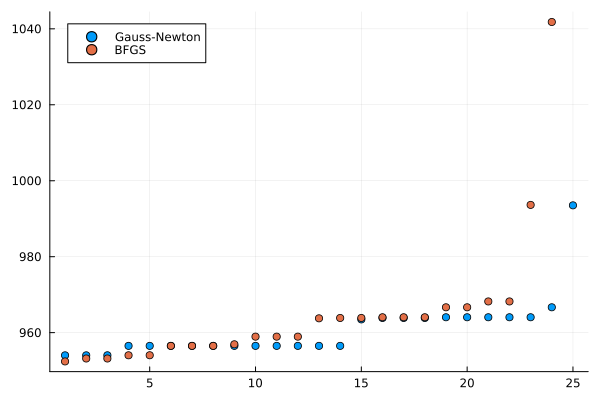

In [22]:
fmins_fides = [res_fides.runs[i].fmin for i in eachindex(res_fides.runs)]
fmins_bfgs = [res_bfgs.runs[i].fmin for i in eachindex(res_bfgs.runs)]
plot(1:length(fmins_fides), sort(fmins_fides), seriestype=:scatter, label="Gauss-Newton")
plot!(1:length(fmins_bfgs), sort(fmins_bfgs), seriestype=:scatter, label="BFGS")

Using the Gauss-Newton Hessian approximation often yields better results than using the BFGS Hessian approximation. However, due to the limited number of initial guesses (only 25 in this demonstration), neither method successfully converged to the global optimum in this case study.

# Next Steps

Beyond parameter estimation, the posterior distribution of model parameter can be inferred with a Bayesian inference approach. This approach allows inherent analysis of the uncertainty of inferred quantities. For those interested in exploring this further, a dedicated notebook on performing Bayesian inference with PEtab is available here ADD.